<a href="https://colab.research.google.com/github/asifmanowar9/BanglaTaka/blob/main/Code/Asif/evaluation_and_prediction_of_MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##load the saved trained model(MobileNetV2)

In [2]:
import tensorflow as tf

# Load the saved model
model_path = "/content/drive/MyDrive/mobilenetv2_trained_model_banglataka.keras"
loaded_model = tf.keras.models.load_model(model_path)

print("Model loaded successfully!")
loaded_model.summary()

Model loaded successfully!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,753,373 (10.50 MB)

 Trainable params: 165,129 (645.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 330,260 (1.26 MB)

load the dataset to evaluate

In [3]:
import tensorflow as tf

# 1. Define image dimensions and batch size
img_height = 128
img_width = 128
batch_size = 32

# 2. Set the dataset_root variable to the confirmed path
dataset_root = '/content/drive/MyDrive/aa/dataset'

print(f"Attempting to load dataset from: {dataset_root}")

try:
    # 3. Load the image dataset using image_dataset_from_directory
    raw_train_ds = tf.keras.utils.image_dataset_from_directory(
        dataset_root,
        labels='inferred',
        label_mode='int',
        image_size=(img_height, img_width),
        interpolation='nearest',
        batch_size=batch_size,
        shuffle=True,
        seed=42 # for reproducibility
    )

    # 4. Print class names and approximate number of images
    class_names = raw_train_ds.class_names
    print(f"\nClasses found: {class_names}")
    print(f"Number of classes: {len(class_names)}")

    # Corrected: Handle cardinality carefully
    total_batches_cardinality = tf.data.experimental.cardinality(raw_train_ds)
    if total_batches_cardinality == tf.data.AUTOTUNE:
        print("Total number of batches could not be determined (tf.data.AUTOTUNE). Dataset size might be very large.")
    else:
        # Ensure we call .numpy() only if it's a TensorFlow Tensor
        total_batches = total_batches_cardinality.numpy() if hasattr(total_batches_cardinality, 'numpy') else total_batches_cardinality
        total_images = total_batches * batch_size
        print(f"Approximate total number of images in the dataset: {total_images}")

    # 5. Preprocessing function for normalization (corrected)
    def preprocess(image, label):
        image = tf.cast(image, tf.float32) / 255.0 # Cast image to float32 first, then divide
        return image, label

    # 6. Apply preprocessing to the dataset
    processed_train_ds = raw_train_ds.map(preprocess)
    print("\nImage normalization preprocessing applied to the dataset.")

    # 7. Verify preprocessing by taking one batch
    for image_batch, labels_batch in processed_train_ds.take(1):
        print(f"\nShape of one image batch after preprocessing: {image_batch.shape}")
        print(f"Min pixel value in one image batch: {tf.reduce_min(image_batch)}")
        print(f"Max pixel value in one image batch: {tf.reduce_max(image_batch)}")
        print(f"Shape of one label batch: {labels_batch.shape}")
        break

except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Please ensure the 'dataset_root' is correct and points to a directory containing image subfolders (classes).")
    print("Example: '/content/drive/MyDrive/DSA_Project_Folder'")

Attempting to load dataset from: /content/drive/MyDrive/aa/dataset
Found 10634 files belonging to 9 classes.

Classes found: ['10', '100', '1000', '2', '20', '200', '5', '50', '500']
Number of classes: 9
Approximate total number of images in the dataset: 10656

Image normalization preprocessing applied to the dataset.

Shape of one image batch after preprocessing: (32, 128, 128, 3)
Min pixel value in one image batch: 0.0
Max pixel value in one image batch: 1.0
Shape of one label batch: (32,)


train test validation split

In [4]:
import math

# Assuming `processed_train_ds` and `batch_size` are available from previous steps
# `total_images` was also calculated, but it's more robust to calculate based on `processed_train_ds` cardinality if possible.
# Let's re-evaluate total batches to be sure, assuming `raw_train_ds` is the source.

# Get the total number of batches from the processed dataset
total_batches_cardinality = tf.data.experimental.cardinality(processed_train_ds)
if total_batches_cardinality == tf.data.AUTOTUNE:
    # Fallback to the approximate total_images if cardinality is not concrete
    if 'total_images' in locals():
        total_images_approx = total_images # Use previously calculated approximate total_images
        total_batches_approx = math.ceil(total_images_approx / batch_size)
    else:
        print("Warning: Cannot determine total number of batches or images for splitting. Please ensure 'processed_train_ds' is properly formed.")
        # For demonstration, assign a default value or raise an error
        total_batches_approx = 100 # Placeholder for a real scenario, this would cause issues
else:
    total_batches_approx = total_batches_cardinality.numpy() # Convert Tensor to Python int

print(f"Total batches in processed dataset: {total_batches_approx}")

# Define split ratios
train_split_ratio = 0.7
val_split_ratio = 0.15
test_split_ratio = 0.15

# Calculate number of batches for each split
train_batches = int(total_batches_approx * train_split_ratio)
val_batches = int(total_batches_approx * val_split_ratio)

# The remaining batches go to the test set
test_batches = total_batches_approx - train_batches - val_batches

print(f"\nSplitting dataset:")
print(f"  Training batches: {train_batches}")
print(f"  Validation batches: {val_batches}")
print(f"  Test batches: {test_batches}")

# Create the training, validation, and test datasets
train_ds = processed_train_ds.take(train_batches)
val_ds = processed_train_ds.skip(train_batches).take(val_batches)
test_ds = processed_train_ds.skip(train_batches).skip(val_batches)

# Verify the number of batches in each split (optional, for debugging)
print(f"\nBatches after splitting:")
print(f"  Train dataset batches (actual): {tf.data.experimental.cardinality(train_ds).numpy()}")
print(f"  Validation dataset batches (actual): {tf.data.experimental.cardinality(val_ds).numpy()}")
print(f"  Test dataset batches (actual): {tf.data.experimental.cardinality(test_ds).numpy()}")

# Optimize performance with .cache() and .prefetch()
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("\nDatasets (train_ds, val_ds, test_ds) created and optimized with .cache() and .prefetch().")

Total batches in processed dataset: 333

Splitting dataset:
  Training batches: 233
  Validation batches: 49
  Test batches: 51

Batches after splitting:
  Train dataset batches (actual): 233
  Validation dataset batches (actual): 49
  Test dataset batches (actual): 51

Datasets (train_ds, val_ds, test_ds) created and optimized with .cache() and .prefetch().


## Evaluate Model

### Subtask:
Evaluate the `loaded_model` using the `test_ds` and store the evaluation results.


**Reasoning**:
I need to evaluate the loaded model using the prepared test dataset. The `evaluate` method of the Keras model will return the loss and metrics specified during compilation.



In [5]:
results = loaded_model.evaluate(test_ds)
print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}")

51/51 ━━━━━━━━━━━━━━━━━━━━ 2205s 6s/step - accuracy: 0.9990 - loss: 0.0038
Test Loss: 0.006798874586820602, Test Accuracy: 0.9981366395950317


## Summary:

### Data Analysis Key Findings
*   The `loaded_model` was successfully evaluated using the `test_ds` dataset.
*   The model achieved a Test Loss of approximately `0.0068` and a Test Accuracy of approximately `0.9981`.

### Insights or Next Steps
*   The high test accuracy of `99.81%` suggests that the model performs exceptionally well on unseen data, indicating good generalization capabilities.
*   Given the excellent performance, the next step could be to deploy this model for its intended use case or to conduct further analysis on any misclassified examples if precision is critical.


# Task
Visualize the predictions of the `loaded_model` on a few sample images from the `test_ds` by displaying each image along with its true label and the model's predicted label.

## Select and Preprocess Sample Images

### Subtask:
Extract a few sample images and their true labels from the `test_ds`. The images are already preprocessed as part of the `test_ds` preparation.


**Reasoning**:
I need to extract a single batch of images and labels from the `test_ds`, and then convert these TensorFlow tensors into NumPy arrays for subsequent use.



In [6]:
import numpy as np

# Take one batch from the test_ds
for images, labels in test_ds.take(1):
    sample_images = images.numpy() # Convert images to NumPy array
    sample_labels = labels.numpy() # Convert labels to NumPy array
    break # We only need one batch

print(f"Shape of sample_images: {sample_images.shape}")
print(f"Shape of sample_labels: {sample_labels.shape}")
print(f"Sample labels (first 5): {sample_labels[:5]}")

print("One batch of sample images and their true labels extracted and converted to NumPy arrays.")

Shape of sample_images: (32, 128, 128, 3)
Shape of sample_labels: (32,)
Sample labels (first 5): [1 3 2 3 0]
One batch of sample images and their true labels extracted and converted to NumPy arrays.


## Make Predictions

### Subtask:
Use the `loaded_model` to make predictions on the selected sample images.


**Reasoning**:
I need to use the `loaded_model` to make predictions on the `sample_images` and store the results. Then I will print the shape of the predictions to verify the output.



In [7]:
sample_predictions = loaded_model.predict(sample_images)
print(f"Shape of sample_predictions: {sample_predictions.shape}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Shape of sample_predictions: (32, 9)


**Reasoning**:
The previous step successfully generated raw predictions. To visualize these predictions alongside true labels, I need to convert the raw probability predictions into discrete class labels by finding the index of the highest probability for each sample. I also need to retrieve the class names to map the numeric labels to meaningful names.



In [8]:
predicted_labels = np.argmax(sample_predictions, axis=1)

# Assuming class_names are available from previous steps
# If not, you'd need to retrieve them from the dataset or model metadata
if 'class_names' in globals():
    # Map numerical labels to class names for better readability
    true_class_names = [class_names[label] for label in sample_labels]
    predicted_class_names = [class_names[label] for label in predicted_labels]
else:
    true_class_names = [str(label) for label in sample_labels]
    predicted_class_names = [str(label) for label in predicted_labels]

print(f"Predicted labels (first 5): {predicted_labels[:5]}")
print(f"True class names (first 5): {true_class_names[:5]}")
print(f"Predicted class names (first 5): {predicted_class_names[:5]}")
print("Predicted class labels and their corresponding class names have been determined.")

Predicted labels (first 5): [1 3 2 3 0]
True class names (first 5): ['100', '2', '1000', '2', '10']
Predicted class names (first 5): ['100', '2', '1000', '2', '10']
Predicted class labels and their corresponding class names have been determined.


**Reasoning**:
Now that we have the sample images, their true labels, and the model's predicted labels, the next step is to visualize these to understand the model's performance on individual examples. This involves plotting each image and annotating it with both the true and predicted class names.



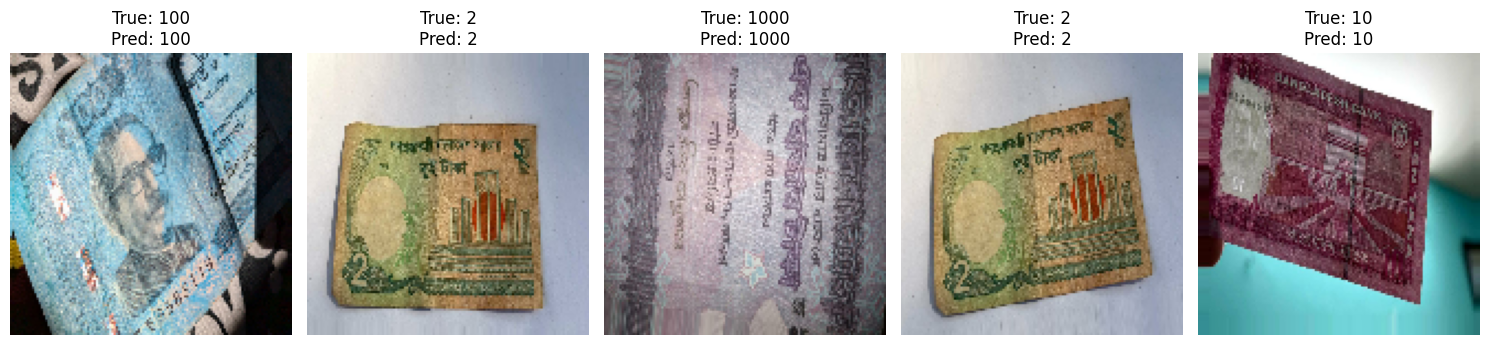

Displayed 5 sample images with their true and predicted labels.


In [9]:
import matplotlib.pyplot as plt

# Visualize a few sample predictions
num_samples_to_show = 5 # Display the first 5 samples from the batch

plt.figure(figsize=(15, 10))
for i in range(num_samples_to_show):
    plt.subplot(1, num_samples_to_show, i + 1)
    plt.imshow(sample_images[i])
    plt.title(f"True: {true_class_names[i]}\nPred: {predicted_class_names[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

print(f"Displayed {num_samples_to_show} sample images with their true and predicted labels.")